In [1]:
import numpy as np
import igraph as ig
from ripser import ripser
from persim import plot_diagrams
from numba import jit
import matplotlib.pyplot as plt
from simulator_pa import pa_generator
import betti

import matplotlib.pyplot as plt

# Preferential Attachment Clique Complex

Welcome! In this notebook, we'll showcase how our results from the paper () are computed.

Introduction


## Graph Generation and Parameter Selection

We'll first generate a scale-free graph using preferential attachment using the function `pa_generator`, which can be found in `simulator_pa.py`. (cite section from paper). The function will output an iGraph object simulated using the preferential attachment model.

For simplicity, we start with small graphs.

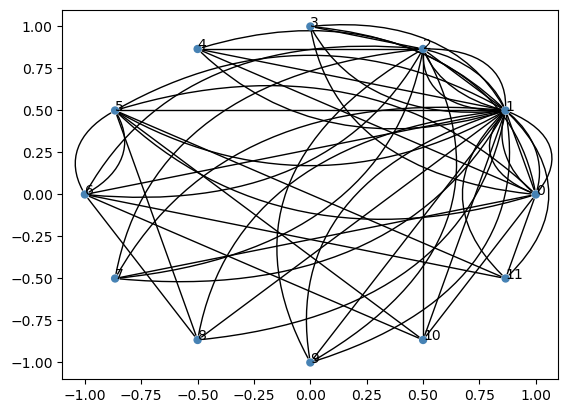

In [24]:
m = 5
delta = -3
T0 = 12
seed = 0
graph = pa_generator(T0, m, delta, seed)
graph.es['color'] = 'black'
graph.vs['color'] = 'gray'

# color newest node and its edges
red_edges = graph.es.select(_source_in=graph.vs.select(11), _target_in=graph.vs.select(11))
red_edges['color'] = 'red'
graph.vs[11]['color'] = 'red'

layout = graph.layout_circle()
labels = [x for x in range(T0)]
fig, ax = plt.subplots()
ig.plot(graph, layout=layout, vertex_label = labels, bbox=(0, 0, 350, 350), target=ax)

The necessary parameters are:

num_nodes (int): Number of nodes in the graph (sometimes denoted as $t$, which stands for the time duration of the simulation).

num_edges_per_new_node (int): Number of edges attached to the new node each time (denoted by $m$).

$\delta$ (float): Parameter to control the rich-gets-richer effect. For smaller (more negative) delta, the effect is stronger.
        The power of of the tail of the degree distribution should be $\tau = 3 + \delta / m$.
        We choose -m < $\delta$ < 0 to ensure 2 < $\tau$ < 3.
        
seed (int): Seed for the random number geneator.




We'll demonstrate the effect of $\delta$ on the scale-freeness of the graphs using slightly larger graphs.

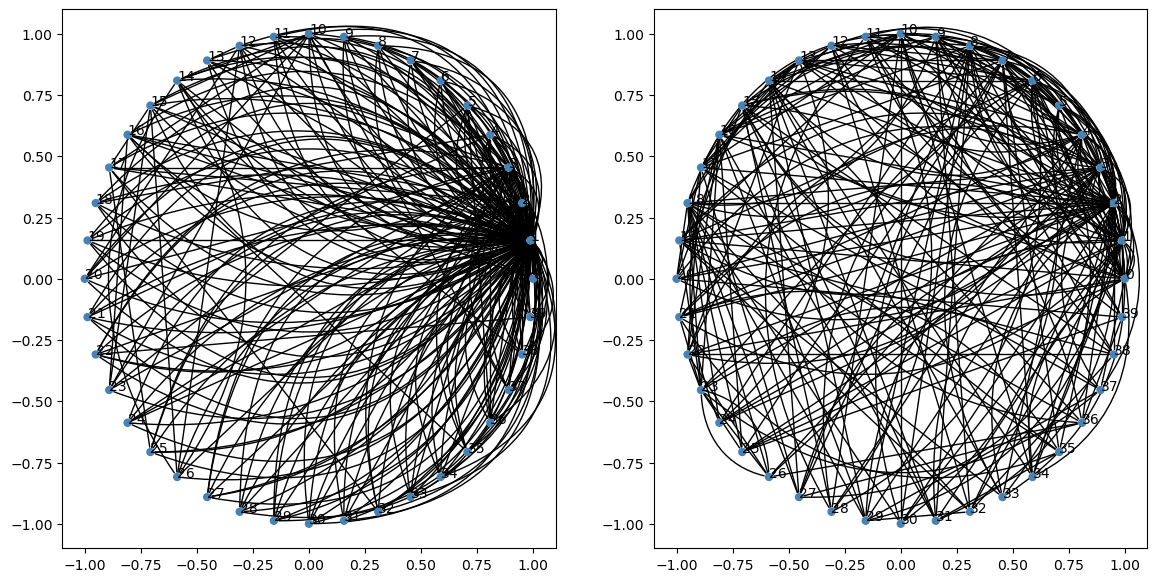

In [23]:
m = 7
T0 = 40
seed = 100
graph0 = pa_generator(T0, m, -6.5, seed)
graph1 = pa_generator(T0, m, -0.5, seed)

labels = [x for x in range(T0)]
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for i, graph in enumerate([graph0, graph1]):
    graph.vs.select([0,1,2,3])['color'] = 'gray'
    grey_edges = graph.es.select(_source_in=graph.vs.select([0,1,2,3]), _target_in=graph.vs.select([0,1,2,3]))
    grey_edges['color'] = '#71797E'
    layout = graph.layout_circle()
    ig.plot(graph, target = axes[i], layout=layout, vertex_label = labels, bbox=(0, 0, 200, 200))
plt.show()

The edges connected to nodes 0, 1, 2 and 3 are colored grey, and the rest are colored black. We can observe from the plots that graph0 (on the left) is highly scale-free, since there are a few nodes (typically nodes appearing early, such as node 0, 1, 2 and 3) with very high degrees (which we can refer to as hubs), while the rest have very low degrees. Most of the edges are actually connected to these hubs. In this case, the scale-free effect is strong in graph1 because the magnitude of m is fairly large. 

On the other hand, the effect is not as obvious in the plot of graph1 (on the right). Although there are a few nodes with higher degrees, the degrees are not as extreme, and the degrees of other nodes are not extremely small. This is because m's magnitude is small, so that the graph is less scale-free.

With the homology of the clique complex of the scale-free network in mind, we tend to select large m and more negative $\delta$ for more interesting results. In the rest of this tutorial, we'll mainly work with $m = 7, \delta = -5$. We are interested in this pair of parameters because
1. $m$ is large enough to generate interesting homology
2. The magnitude of $\delta$ is large enough to showcase scale-free effects.

### Optional Parameters (Feel Free to Skip Ahead and Return Later)

There are a few optional parameters in `pa_generator` that don't impact the basic properties of the generated graphs. These parameters were added for performance or bookkeeping purposes.

`polya_flag` is a Boolean parameter to indicate whether to use Definition 2 in [Garavaglia 2019] for graph generation. The algorithm with `polya_flag = True` is generally faster. Note that the output graph is different when the `polya_flag` argument is different.

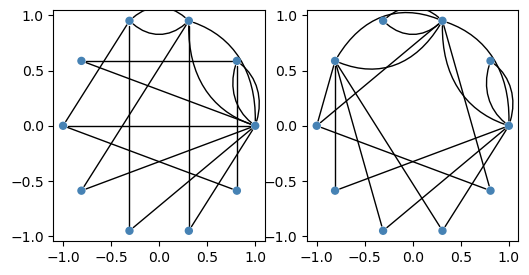

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
graph0 = pa_generator(10, 2, -1, seed=0, polya_flag=True)
graph1 = pa_generator(10, 2, -1, seed=0, polya_flag=False)

for i, graph in enumerate([graph0, graph1]):
    layout = graph.layout_circle()
    ig.plot(graph, layout = layout, target = axes[i])
plt.show()

`sorted_flag` is a Boolean parameter. It's relevant only if `polya_flag = True`. It indicates whether edges with the same child are to be sorted by parents in the output graph in the simulation, which is useful for counting the edges' multiplicity. It changes the indices of the graph edges but doesn't impact the graph structure.

`early_exit` is a nonnegative integer parameter, relevant only if `polya_flag = True`. It terminates the graph's construction once the number of nodes reaches early_exit. While the distribution is the same as that of the graph with the same number of nodes, this parameter ensures that the same graph is obtained when the same seed is applied.

In graph 0, node 3 is connected to the following prior nodes:
[2 2]
In graph 1, node 3 is connected to the following prior nodes:
[1 2]
In graph 2, node 3 is connected to the following prior nodes:
[1 2]


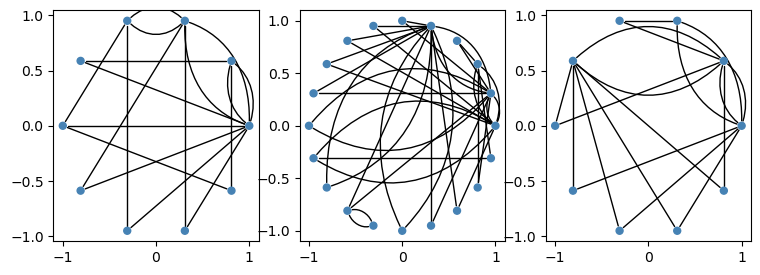

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

m = 2
delta = -1

graph0 = pa_generator(10, m, delta, seed = 0, polya_flag=True)
graph1 = pa_generator(20, m, delta, seed = 0, polya_flag=True)
graph2 = pa_generator(20, m, delta, seed = 0, polya_flag=True, early_exit = 10)

node = 3

for i, (graph, ax) in enumerate(zip([graph0, graph1, graph2], axes)):
    layout = graph.layout_circle()
    ig.plot(graph, layout = layout, target = ax)
    
    edge_list = np.array([e.tuple for e in graph.es])
    prior_nodes = edge_list[(node-1)*m : node*m, 0]
    
    print(f"In graph {i}, node {node} is connected to the following prior nodes:")
    print(edge_list[(node-1)*m : node*m, 0])

plt.show()

graph3 is the induced subgraph of graph2 on the first 10 nodes. It is **different** from graph1 because the graph is sampled differently with the same number of nodes.

`python_object_flag` is a Boolean parameter. It indicates whether to output the graph as an igraph graph object (as opposed to an edge list)

In [14]:
graph0 = pa_generator(10, 2, -1, seed=0, python_object_flag=True)
graph1 = pa_generator(10, 2, -1, seed=0, python_object_flag=False)
print('Type of graph0: ', type(graph0))
print('Type of graph1: ', type(graph1))

Type of graph1:  <class 'igraph.Graph'>
Type of graph2:  <class 'list'>


## Betti Numbers and Ripser

The results in our paper concerns the Betti numbers of the preferential attachment graphs. The Betti numbers can be computed using the package `ripser`. In fact, the package computes the more general "persistent Betti numbers", which can be visualized by "persistence diagrams". Below, we illustrate these concepts and the package with simple examples.

Betti numbers are numerical description of a class of combinatorial objects called "simplicial complexes", which consist of vertices, edges, triangles, tetrahedra, etc. The Betti number $\beta_q$ of a simplicial complex at dimension $q$ is, roughly speaking, the number of $q^{th}$-dimensional holes in the object, with the exception that $\beta_0$ is the number of components. We often speak of holes and components as *homological features*. Below are some examples:
* the 1-dimensional Betti number of a hollow square (with 4 nodes and 4 edges) is 1,
* the 1-dimensional Betti number of two hollow squares sharing an edge is 2, and 
* the 1-dimensional Betti number of one hollow and one filled square glued together is 1.

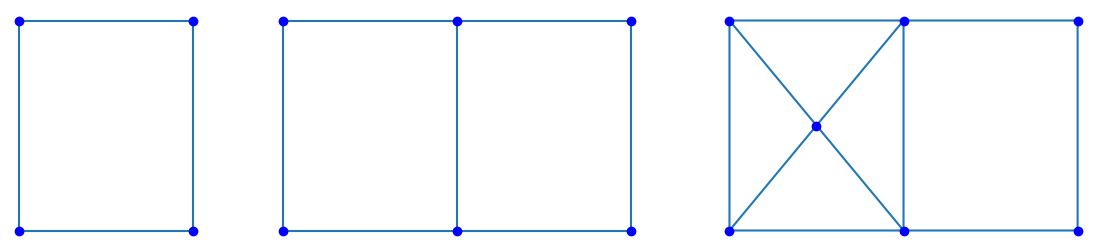

In [22]:
fig, axes = plt.subplots(1,3, figsize=(14, 3), width_ratios=[1, 2,2])

ax = axes[0]
ax.plot(*zip((0,0), (1,0), (1,1), (0,1),(0,0)))
ax.plot([0,0,1,1],[0,1,0,1], 'bo')

ax = axes[1]
ax.plot(*zip((1,1),(1,0),(0,0),(0,1),(1,1),(2,1),(2,0),(1,0)))
ax.plot([0,0,1,1,2,2],[0,1,0,1,0,1], 'bo')

ax = axes[2]
ax.plot(*zip((0,0),(0,1),(1,1),(0,0),(1,0),(2,0),(2,1),(1,1),(1,0),(0,1)))
ax.plot([0,0,1,1,2,2,0.5],[0,1,0,1,0,1,0.5], 'bo')

for ax in axes:
    ax.axis('off')
plt.show()

In figure 3, the square on the left is filled.

A simplicial complex X is said to be a *clique complex* if it contains a simplex whenever it contains all edges of the simplex. All three examples above are clique complexes.

`Risper` keeps track of the changes in Betti numbers of the clique complex of a graph as vertices and edges are added to a simplicial complex one by one. To illustrate this, consider the simple example below.

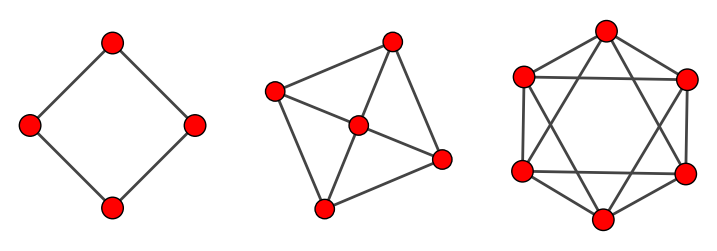

In [ ]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize = (9,3))

graph0 = ig.Graph()
graph0.add_vertices(4)
graph0.add_edges([(0,1), (1,2), (2,3), (0,3)])
ig.plot(graph0, target = ax0)

graph1 = graph0.copy()
graph1.add_vertices(1)
graph1.add_edges([(0,4),(1,4),(2,4),(3,4)])
ig.plot(graph1, target = ax1)

graph2 = graph1.copy()
graph2.add_vertices(1)
graph2.add_edges([(0,5),(1,5),(2,5),(3,5)])
ig.plot(graph2, target = ax2)

plt.show()

We have 3 graphs, each time adding an extra nodes and 4 edges. We'll use Ripser to keep track of the evolution of the Betti numbers of the clique complexes of these graphs.

To use Ripser, we'll use the function get_age_matrix() from betti.py, which constructs a matrix describing the age of each edge and vertex. The age of an edge is when the edge appears in the graph, i.e., max(node1, node2). The age of an vertex is the time it appears. Since we add vertices one at a time, the age of each vertex is distinct.

Ripser takes the matrix and a maximum dimension as inputs to form the persistent diagram, which keeps tract of the *persistent Betti numbers*. The function translate_PD_to_betti() takes the persistent diagram and the number of nodes as inputs to calculate the Betti number.

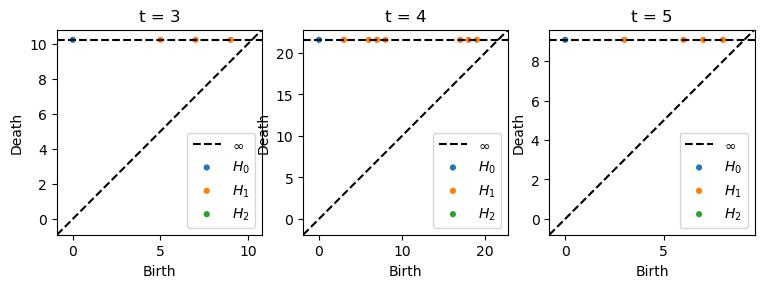

In [35]:
fig, axes = plt.subplots(1,3,figsize = (9,3))

for i, graph in enumerate([graph0, graph1, graph2]):
    mat = betti.get_age_matrix(graph)
    dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
    plot_diagrams(dgms, ax = axes[i], title = f't = {i + 3}')

plt.show()

A plot below the horizontal dotted line indicates that a homological feature is born at the value of its x-coordinate and is filled (dies) at the value of its y-coordinate. A point on the dotted line indicates that a homological feature is born at the value of its x-coordinate and is never filled.

When t = 3, we see that the orange dot appears at birth = 3 and death = infinity (at the dotted line). The orange dot indicates that a 1-dim hole is born at time = 3, as the square is formed. Betti 1 is calculated to be 1 and Betti 2 is 0.

When t = 4, since the square is filled by the new node, the hole we saw previously "dies" at time = 4, so the orange dot is shown to have birth = 3 and death = 4. Correspondingly, Betti 1 goes back to 0 at time = 4. Currently, Betti 1 is 0 and Betti 2 is 0

When t = 5, we see a new green dot appears at birth = 5 and death = infinity. It indicates that the first 2nd-dim hole is born. Now, Betti 1 is 0 and Betti 2 is 1.

Now, let's do the same calculation for a larger graph.

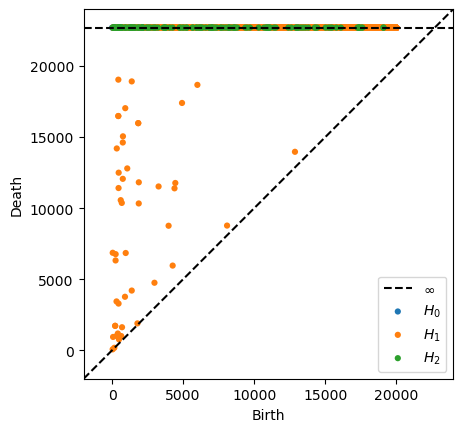

In [ ]:
num_nodes = 20000
graph = pa_generator(num_nodes, 7, -5, 0)
mat = betti.get_age_matrix(graph) # obtain the age matrix of the complex as an input for ripser
dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms'] # get the persistence diagrams
plot_diagrams(dgms)

The function `translate_PD_to_betti` translates a persistent diagram (with a dimension of user's choice) to an array of Betti numbers at each time step. We use this function to show the growth of Betti numbers.

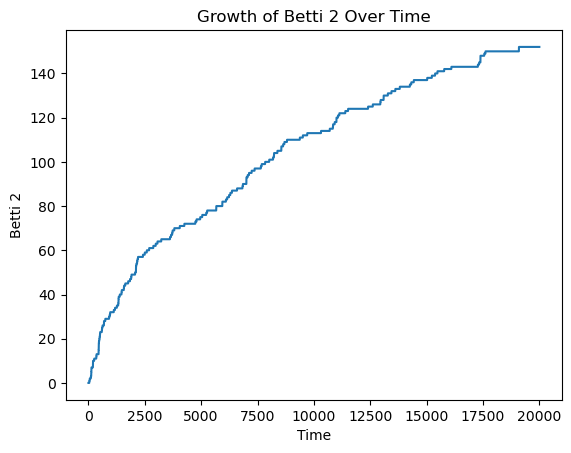

In [ ]:
betti2_actual = betti.translate_PD_to_betti(dgms[2], num_nodes) # read the betti numbers from persistence diagrams
plt.plot(betti2_actual)
plt.xlabel('Time')
plt.ylabel('Betti 2')
plt.title('Growth of Betti 2 Over Time')
plt.show()

## Bounds on Betti Numbers

In this section, we illustrate the bounds on the Betti numbers in our paper. Not only are these bounds analytically more tractible, their computations are also easier. We first generate a large graph.

In [36]:
m = 7
delta = -5
num_nodes = 1000
seed = 1
graph = pa_generator(num_nodes, m, delta, seed)
edge_list = np.array([e.tuple for e in graph.es]) # For technical reason, we extract the edge list of the graph."

In [37]:
mat = betti.get_age_matrix(graph)
dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
actual = betti.translate_PD_to_betti(dgms[2], num_nodes)

Before we state the bounds, a number of definitions are in place.

For every node $t$, the *parent subcomplex*, denoted by $L^{(t)}$, is the subcomplex formed by nodes that precede node $t$ and are adjacent to node $t$. 

The upper bound is straight-forward: $$\beta_q \leq \sum \text{rk } H_{q-1}(L^{(t)}),$$ where the sum ranges over all nodes $t$. We can get the summands of the upper bound with the following function.

In [38]:
q = 2
maxdim = q
parents_betti = betti.betti_numbers_of_links(graph, num_nodes, m, maxdim)
upper = np.cumsum(parents_betti[q-1, :])

The first argument is the graph, the second and third are the graph's parameters.

The function `betti_numbers_of_links` computes the Betti numbers of the parent subcomplexes of all nodes up to dimension `maxdim`. Each column corresponds to a node and each row corresponds to a dimension.

We could have set `maxdim` to be $q-1$ if we were only interested in the upper bound. However, we set it as $q$ because the Betti numbers at dimension $q$ will be relevant for the lower bounds.

### Definitions of the Lower Bounds

The lower bound requires two more definitions.

First, observe that $L^{(t)}$ is a subcomplex $X^{(t-1)}$ formed by all nodes preceding node $t$, and hence the inclusion induces a map $f^{(t)}_{q-1}: H_{q-1}(L^{(t)}) \to H_{q-1}(X^{(t-1)})$ between homology groups.

Second, for each node $t$, let $(S^q)^{(t)}$ be the event where
* the first $2q$ nodes form a $(q-1)$-dimensional sphere $S^{q-1}$, and
* node $2q+1$ and node $t$ are both adjacent to all the first $2q$ nodes.
On this event, the first $2q + 1$ nodes along with $t$ forms a $q$-dimensional sphere $S^q$.

We are now ready to state the lower bounds:
$$\beta_q \geq \sum \mathbf{1}[(S^q)^{(t)}] - \sum \mathbf{1}[(S^q)^{(t)}] \mathbf{1}[\text{rk }\ker j_{q-1} = 1] - \sum \text{rk } H_{q}(L^{(t)}),$$
where $j_{q-1}: S^q \to L^{(t)}$ is induced by inclusion of the first $2q$ nodes (which forms a sphere) into $L^{(t)}$.

This is slightly different from the bound in Proposition 14. The bound there is not readily computable because of presence of relative Betti numbers. The bound here is slightly weaker (as one can see by tracing through the proof) but is more computable. 

While the definition of this event helps with analytical estimation, this event happens with an exceedingly low probability. We define an analogous event that happen more often. Let $(\hat S^q)^{(t)}$ be the event where
* some $2q$ nodes among the first 20 nodes form a $(q-1)$-dimensional sphere $S^{q-1}$,
* node $t$ is adjacent to all the these $2q$ nodes (when there are multiple sets of such $2q$ nodes, we pick the first set in an arbitrary deterministic ordering), and
* node $t$ is not the first such nodes, i.e. some preceding nodes are also adjacent to all the $2q$ nodes.

There is an analogous bound for $(\hat S^q)^{(t)}$:
$$\beta_q \geq \sum \mathbf{1}[(\hat S^q)^{(t)}] - \sum \mathbf{1}[(\hat S^q)^{(t)}] \mathbf{1}[\text{rk }\ker j_{q-1} = 1] - \sum \text{rk } H_{q}(L^{(t)}),$$
where $\hat j_{q-1}: S^q \to L^{(t)}$ is induced by inclusion of the sphere in the definition of $(\hat S^q)^{(t)}$ to $L^{(t)}$

### Computations of the Lower Bounds

We will showcase individual functions that compute the different terms above. At the end of the section, we showcase a one-line function that computes everything in one go. The individual functions require the edge list of the graph as an argument.

From the formulae of the lower bounds, the last term can be computed with `betti_numbers_of_links`.

In [39]:
third_term = np.cumsum(parents_betti[q, :])

For the first two terms, we first decide whether some $2𝑞$ nodes among the first few nodes form a $(𝑞−1)$-dimensional sphere $𝑆^{𝑞−1}$ with the function `check_square_appearance`.

In [40]:
specific_sphere = np.arange(4)
time_limit = 20

In [41]:
boo_initial_square, initial_square = betti.check_square_appearance(graph, specific_sphere)
boo_initial_square_hat, initial_square_hat = betti.check_square_appearance(graph, time_limit)
print(boo_initial_square)
print(boo_initial_square_hat)

False
True


The second argument of `check_square_appearance` can be a specific list of $2q$ nodes (in this case the first 4 nodes), or a time limit until which the alogrithm searches for a sphere (in this case the first 20 nodes).
The first output is a boolean variable that indicates whether the desired sphere exists, and if it does, its nodes are stored in the second output. Clearly, if the sphere does not exist, both the first and the second terms are zero.

In [42]:
if not boo_initial_square:
    first_term = np.zeros(num_nodes, dtype=int)
    second_term = np.zeros(num_nodes, dtype=int)
if not boo_initial_square_hat:
    first_term_hat = np.zeros(num_nodes, dtype=int)
    second_term_hat = np.zeros(num_nodes, dtype=int)

Now, we proceed assuming the boolean variables are both `True`. The binary summands of the first two sums can be computed with the function `first_summand_lower_bound` and `second_summand_lower_bound`. Note that latter function needs the ouptut of the first function to avoid repeated computations.

In [43]:
if boo_initial_square:
    first_summand = betti.first_summand_lower_bound(edge_list, num_nodes, m, initial_square)
    first_term = np.cumsum(first_summand)
    second_summand = betti.second_summand_lower_bound(graph, num_nodes, initial_square, first_summand)
    second_term = np.cumsum(first_summand)

if boo_initial_square_hat:
    first_summand_hat = betti.first_summand_lower_bound(edge_list, num_nodes, m, initial_square_hat)
    first_term_hat = np.cumsum(first_summand_hat)
    second_summand_hat = betti.second_summand_lower_bound(graph, num_nodes, initial_square_hat, first_summand_hat)
    second_term_hat = np.cumsum(first_summand_hat)

We can then aggregate the terms to give the lower bounds:

In [44]:
lower = first_term - second_term - third_term
lower_hat = first_term_hat - second_term_hat - third_term # There is no hatted version for the third term.

We can also use the one-line function to get the same result. The auxiliary variables are the outputs of `first_summand_lower_bound`, `second_summand_lower_bound`, and `betti_numbers_of_links` respectively.

In [45]:
lower_one_line, aux1, aux2, aux3 = betti.betti2_lower_bound(graph, specific_sphere)
lower_one_line_hat, aux1_hat, aux2_hat, aux3_hat = betti.betti2_lower_bound(graph, time_limit)
print(all(lower_one_line_hat == lower_hat))
print(all(aux1_hat == first_summand_hat))
print(all(aux2_hat == second_summand_hat))
print(all(np.cumsum(aux3_hat[2, :]) == third_term))

True
True
True
True


If some terms have been precomputed, we also include them as optional arguments to speed up the one-line computation.

In [46]:
lower_hat_one_line_half_precomputed, _, _, _ = betti.betti2_lower_bound(graph, time=time_limit, first_summand=first_summand_hat, second_summand=second_summand_hat, links_betti_nums=parents_betti)

## Result Replications

Now, we can plot the the actual Betti numbers, the upper bound, and the lower bound to verify that the bounds hold for the graph we generated. Note that the lower bound can be 0, or even negative.

Text(0.5, 1.0, 'Betti 2 and its Bounds')

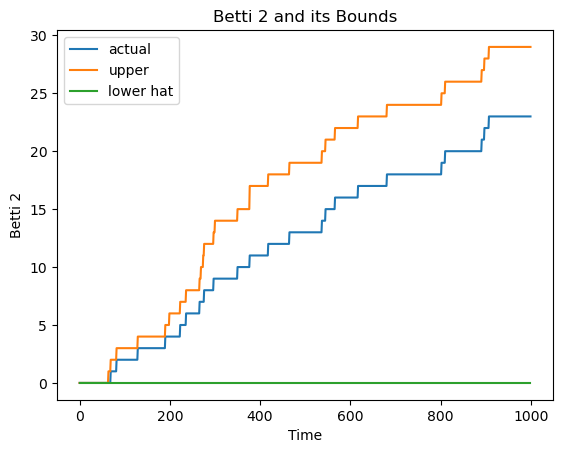

In [49]:
fig, ax = plt.subplots()

ax.plot(actual, label = 'actual')
ax.plot(upper, label = 'upper')
ax.plot(lower_hat, label = 'lower hat')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Betti 2')
ax.set_title('Betti 2 and its Bounds')

We can repeat similar calculations to find the mean of Betti numbers to observe behavior. The simulation we used in the paper generates 500 graphs of T = 10^4, and takes the sample mean of the Betti numbers. We'll use smaller parameters to reduce the runtime. 

Text(0.5, 1.0, 'Log-log Plot of Average Betti 2 and its Bounds')

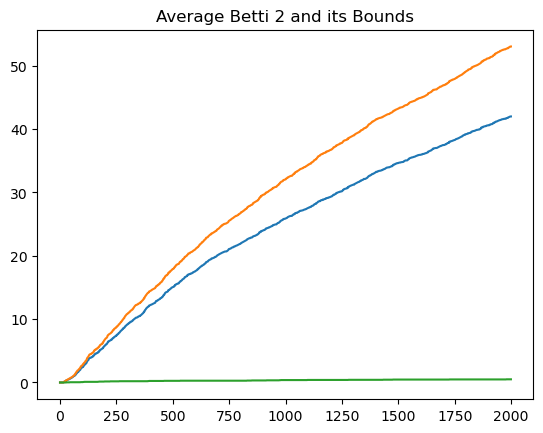

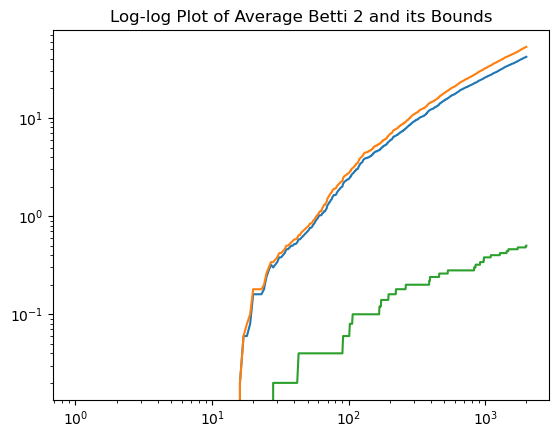

In [50]:
n_samples = 50
num_nodes = 2000
betti2_actual_mean = np.zeros(num_nodes)
betti2_upper_mean = np.zeros(num_nodes)
betti2_lower_mean = np.zeros(num_nodes)
for n in range(n_samples):

    graph = pa_generator(num_nodes, m, delta, n**3)
    mat = betti.get_age_matrix(graph)
    dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
    betti2_actual_mean += betti.translate_PD_to_betti(dgms[2], num_nodes)
    
    parents_betti = betti.betti_numbers_of_links(graph, num_nodes, m, maxdim)
    betti2_upper_mean += np.cumsum(parents_betti[q-1, :])
    
    lower_hat, aux1_hat, aux2_hat, aux3_hat = betti.betti2_lower_bound(graph, time_limit)
    betti2_lower_mean += lower_hat
    
betti2_actual_mean /= n_samples
betti2_upper_mean /= n_samples
betti2_lower_mean /= n_samples

fig, ax = plt.subplots()
ax.plot(betti2_actual_mean, label = 'actual')
ax.plot(betti2_upper_mean, label = 'upper')
ax.plot(betti2_lower_mean, label = 'lower hat')
ax.set_title('Average Betti 2 and its Bounds')

fig, ax = plt.subplots()
ax.loglog(betti2_actual_mean, label = 'actual')
ax.loglog(betti2_upper_mean, label = 'upper')
ax.loglog(betti2_lower_mean, label = 'lower hat')
ax.set_title('Log-log Plot of Average Betti 2 and its Bounds')